# How to generate a simulated timeline and produce a map with `litebird_sim`

**Attention! This notebook can work only after having downloaded the Litebird IMO information.**

You will have to ask the permission to access the private repository https://github.com/litebird/litebird_imo and then install it following [the documentation](https://litebird-sim.readthedocs.io/en/master/tutorial.html#interacting-with-the-imo).

To run this notebook, you should create and activate a new virtual environment with the commands

```
python -m venv ./my_venv
source ./my_venv/bin/activate
```

(you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

```
pip install jupyter litebird_sim
```

If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a *development install* instead:

```
cd /my/local/copy/litebird_sim
pip install .
```

## Set up the environment

In [1]:
# Using this file, we can use "import litebird_sim" even if it is not installed system-wide
import fixpythonpath

We start by importing a few libraries that will be useful in this notebook.

In [2]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from astropy.time import Time

%matplotlib inline

# Produce a simulated timeline


We will simulate 4 detectors of 140 GHz MFT. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version 1.3 (**new!**), and we will simulate 2 hours of observation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/simulations.html#simulations) for more details about the input parameters.

In [3]:
telescope = "MFT"
channel = "M1-140"
detlist = [
    "001_002_060_45A_140_T",
    "001_003_000_75A_140_B",
    "001_003_001_15B_140_T",
    "001_003_002_60A_140_B",
]

start_time = Time("2025-01-01T00:00:00")
mission_time_hours = 1

imo_version = "v1.3"

# Resolution of the input maps
nside = 256

In [4]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    start_time=start_time,
    duration_s=mission_time_hours * 3600.0,
    random_seed=12345,
)

The following instructions load from the IMO the information about the [instrument](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) and the [detectors](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) used in the simulation.

In [5]:
# Load the definition of the instrument (LFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    dets.append(det)

Now we set the scanning strategy retriving the parameters from the IMO

In [6]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

Let's now create a set of «[observations](https://litebird-sim.readthedocs.io/en/latest/observations.html#observations)». For the sake of simplicity, we create just *one* observation, but of course in realistic simulations you will have several observations spread among the available MPI processes.

In [7]:
# creating one observation
sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

The call above allocated the memory necessary to hold the TOD samples.

TODs are not enough to produce maps, as we need *pointing information* too: this is the direction and orientation of each receiver as a function of time.

Before, we set the HWP and then we compute the pointing information that is stored in the observations.

In [8]:
sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
sim.compute_pointings()

Now we know where the detectors are looking at. Let's produce a synthetic image of the sky at the frequencies sampled by the two detectors we're simulating; for this, we need the information about the [frequency channel](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) we are simulating (140 GHz), so we retrieve them from the IMO again:

In [9]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

The LiteBIRD Simulation Framework provides [MBS](https://litebird-sim.readthedocs.io/en/latest/sky_maps.html#synthetic-sky-maps), which is a wrapper to PySM; we use it to produce a map of the sky including synchrotron, free-free, and dust, and we smooth the map according to the FWHM specified in the IMO. (Note that we do not need to pass this information explicitly, as MBS is able to extract it from `ch_info`.)

In [10]:
# let's make an input CMB+foreground map

# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    nside=nside,
    units="K_CMB",
)

mbs = lbs.Mbs(simulation=sim, parameters=Mbsparams, channel_list=ch_info)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2023-08-03 08:49:24,690 INFO MPI#0000] generating and saving cmb simulations
[2023-08-03 08:49:24,783 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-08-03 08:49:24,784 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-08-03 08:49:25,087 INFO MPI#0000] Access data from /home/tomasi/Documents/work/LiteBIRD/simulations/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_230803.fits
[2023-08-03 08:49:25,090 INFO MPI#0000] NSIDE = 256
[2023-08-03 08:49:25,091 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:25,092 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2023-08-03 08:49:25,353 INFO MPI#0000] generating and saving fg simulations
[2023-08-03 08:49:25,356 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-08-03 08:49:25,387 INFO MPI#0000] NSIDE = 512
[2023-08-03 08:49:25,388 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:25,389 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-08-03 08:49:25,618 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-08-03 08:49:25,622 INFO MPI#0000] NSIDE = 512
[2023-08-03 08:49:25,622 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:25,623 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-08-03 08:49:25,816 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-08-03 08:49:25,819 INFO MPI#0000] NSIDE = 512
[2023-08-03 08:49:25,819 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:25,820 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-08-03 08:49:28,758 INFO MPI#0000] Retrieve data for pysm

It's time to fill tods of the observations, with the `signal` we want, in this case CMB and Foreground just generated, dipole (orbital and solar) and noise.

In [11]:
sim.fill_tods(maps)
sim.add_dipole()
sim.add_noise(random=sim.random)

Text(0, 0.5, 'Signal [K]')

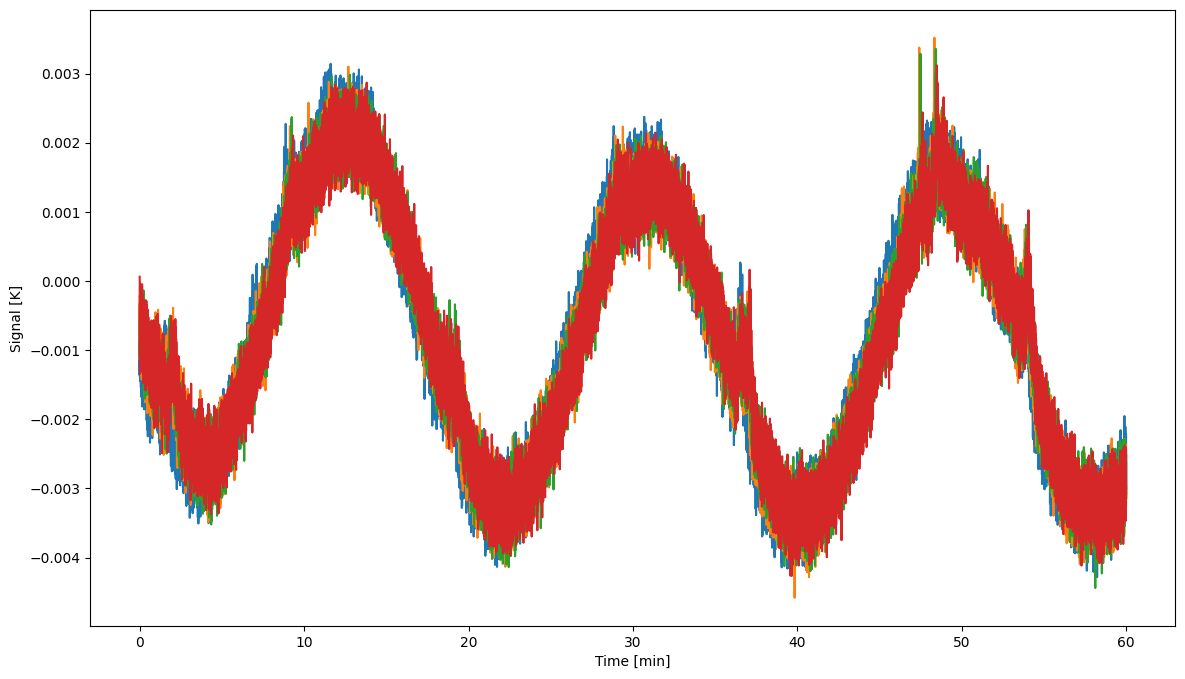

In [12]:
times_min = (
    sim.observations[0].get_times() - sim.observations[0].start_time.cxcsec
) / 60.0
plt.figure(figsize=(14, 8))
plt.plot(times_min, sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[1])
plt.plot(times_min, sim.observations[0].tod[2])
plt.plot(times_min, sim.observations[0].tod[3])

plt.xlabel("Time [min]")
plt.ylabel("Signal [K]")

# Produce a simulated map

In this part, instead, we will simulate 2 detectors of 140 GHz MFT. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version 1.3 (**new!**), and we will simulate 1 year of observation at a lower sampling rate for reduce the memory requrements.

In [13]:
telescope = "MFT"
channel = "M1-140"
detlist = [
    "001_002_060_45A_140_T",
    "001_003_000_75A_140_B",
]

start_time = 0
mission_time_days = 365

imo_version = "v1.3"

# Resolution of the input maps
nside = 256

In [14]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
    random_seed=12345,
)

In [15]:
# Load the definition of the instrument (LFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = 1.0
    dets.append(det)

In [16]:
# let's make an input CMB+foreground map
# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    nside=nside,
)

mbs = lbs.Mbs(simulation=sim, parameters=Mbsparams, detector_list=dets)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2023-08-03 08:49:39,166 INFO MPI#0000] generating and saving cmb simulations
[2023-08-03 08:49:39,305 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-08-03 08:49:39,306 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-08-03 08:49:39,655 INFO MPI#0000] Access data from /home/tomasi/Documents/work/LiteBIRD/simulations/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_230803.fits
[2023-08-03 08:49:39,663 INFO MPI#0000] NSIDE = 256
[2023-08-03 08:49:39,666 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:39,668 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2023-08-03 08:49:40,057 INFO MPI#0000] generating and saving fg simulations
[2023-08-03 08:49:40,059 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-08-03 08:49:40,063 INFO MPI#0000] NSIDE = 512
[2023-08-03 08:49:40,064 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:40,065 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-08-03 08:49:40,296 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-08-03 08:49:40,302 INFO MPI#0000] NSIDE = 512
[2023-08-03 08:49:40,306 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:40,310 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-08-03 08:49:40,590 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-08-03 08:49:40,595 INFO MPI#0000] NSIDE = 512
[2023-08-03 08:49:40,598 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:40,601 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-08-03 08:49:40,947 INFO MPI#0000] Retrieve data for pysm

In [17]:
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,
)

sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
sim.compute_pointings()

In this case we fill the tods with only CMB, Foreground and white noise.

In [18]:
sim.fill_tods(maps)
sim.add_noise(random=sim.random, noise_type="white")

Then we simply bin the observations into maps.

In [19]:
binner_results = sim.make_binned_map(nside=nside)
binned = binner_results.binned_map

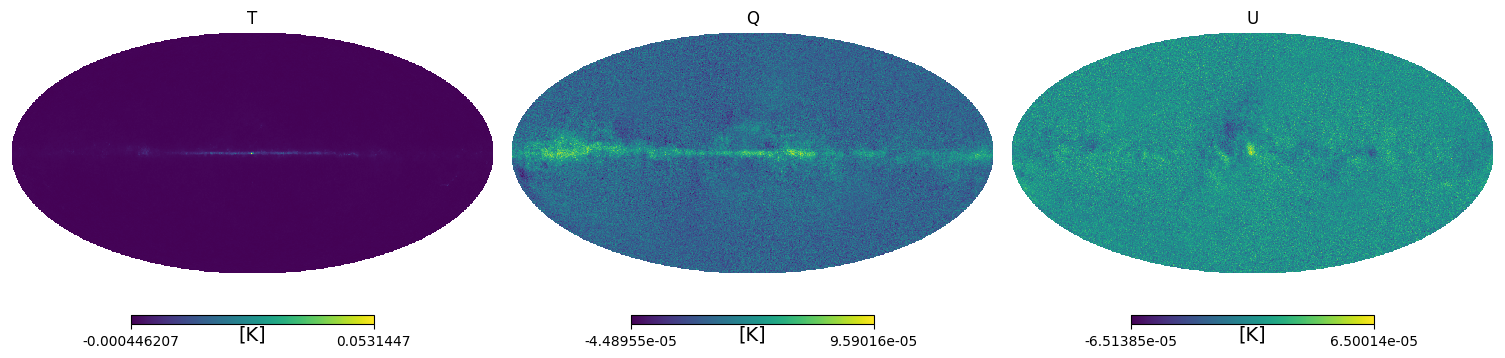

In [20]:
plt.figure(figsize=(15, 8))
hp.mollview(binned[0], sub=131, title="T", unit=r"[K]")
hp.mollview(binned[1], sub=132, title="Q", unit=r"[K]")
hp.mollview(binned[2], sub=133, title="U", unit=r"[K]")